In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Tuple

In [2]:
"""
Computes the following chain of quantities used in the paper/discussion:
1) alpha = G M mu / c^2 (dimensionless)
2) E_obs ≈ 0.3 * eps * alpha^(7/2) * Lambda (V m^-1)
3) a0 = e E_obs / (m_e omega), gamma = sqrt(1 + a0^2)
4) suppression S = gamma * (mu / omega_p)^2 (collisionless regime)
"""

# Physical constants (SI)
G = 6.67430e-11 # gravitational constant, m^3 kg^-1 s^-2
c = 299792458 # speed of light, m s^-1
hbar = 1.054571817e-34 # reduced Planck constant, J s
e_charge = 1.602176634e-19 # elementary charge, C
m_e = 9.10938356e-31 # electron mass, kg

# Utility/conversion functions
def omega_p_eV_from_ne_cm3(n_e_cm3: float) -> float:
    """
    Parameters
    - n_e_cm3 (float): electron density in cm^-3

    Returns
    - omega_p_eV (float): plasma frequency in eV
    """
    omega_p_eV = 3.713e-11 * np.sqrt(n_e_cm3)
    return omega_p_eV


def mu_eV_to_m_minus1(mu_eV: float) -> float:
    """
    Parameters
    - mu_eV (float): dark photon mass in eV

    Returns
    - mu_m_minus1 (float): dark photon mass in m^-1
    """
    mu_m_minus1 = mu_eV / (hbar * c / e_charge)
    return mu_m_minus1


def gravitational_radius(M_kg: float) -> float:
    """
    Parameters
    - M_kg (float): black hole mass in kg

    Returns
    - r_g (float): gravitational radius in m
    """
    r_g = G * M_kg / c**2
    return r_g


def alpha_from_M_mu(M_kg: float, mu_eV: float) -> float:
    """
    Parameters
    - M_kg (float): black hole mass in kg
    - mu_eV (float): dark photon mass in eV

    Returns
    - alpha (float): gravitational fine-structure constant alpha = G M mu (dimensionless)
    """
    r_g = gravitational_radius(M_kg)
    mu_m_minus1 = mu_eV_to_m_minus1(mu_eV)
    return r_g * mu_m_minus1

# Physics formulas
def E_obs_from_eps_alpha(eps: float, alpha: float, Lambda: float) -> float:
    """    
    Parameters
    - eps (float): kinetic mixing (dimensionless)
    - alpha (float): gravitational fine-structure constant alpha = G M mu (dimensionless)
    - Lambda (float): characteristic field strength in V m^-1

    Returns
    - E_obs (float): observed electric field in V m^-1
    """
    return 0.3 * eps * alpha**(7 / 2) * Lambda


def gamma_from_E_and_mu(E_Vm_minus1: float, mu_eV: float) -> Tuple[float, float]:
    """
    Parameters
    - E_Vm_minus1 (float): electric field in V m^-1
    - mu_eV (float): dark photon mass in eV

    Returns
    - a0 (float): quiver parameter (dimensionless)
    - gamma (float): Lorentz boost (dimensionless)
    """
    omega_rad = mu_eV * e_charge / hbar # angular frequency in rad/s
    a0 = (e_charge * E_Vm_minus1) / (m_e * omega_rad)
    gamma = np.sqrt(1 + a0**2)
    return a0, gamma

def suppression_S(M_kg: float, mu_eV: float, eps: float, Lambda: float, n_e_cm3: float) -> float:
    """
    Parameters
    - M_kg (float): black hole mass in kg
    - mu_eV (float): dark photon mass in eV
    - eps (float): kinetic mixing (dimensionless)
    - Lambda (float): characteristic field strength in V m^-1
    - n_e_cm3 (float): electron density in cm^-3

    Returns
    - S (float): suppression factor (dimensionless)
    """
    alpha = alpha_from_M_mu(M_kg, mu_eV)
    E = E_obs_from_eps_alpha(eps, alpha, Lambda)
    a0, gamma = gamma_from_E_and_mu(E, mu_eV)
    omega_p_eV = omega_p_eV_from_ne_cm3(n_e_cm3)
    S = gamma * (mu_eV / omega_p_eV)**2
    return S

# Pretty-print helpers
def fmt_scientific(x: float, sig: int = 3) -> str:
    """
    Format a float in scientific notation with specified significant figures.

    Parameters
    - x (float): number to format
    - sig (int): significant figures

    Returns
    - formatted string
    """
    return f"{x:.{sig}e}"

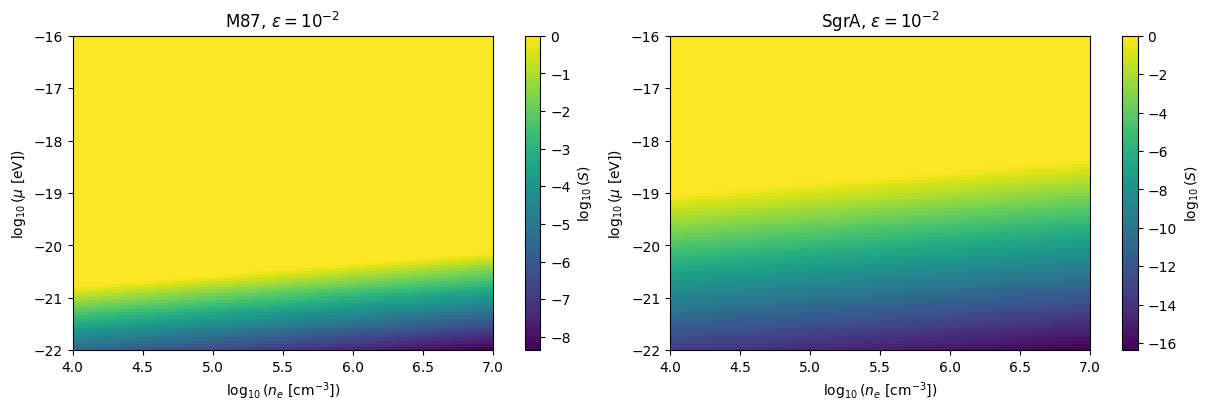

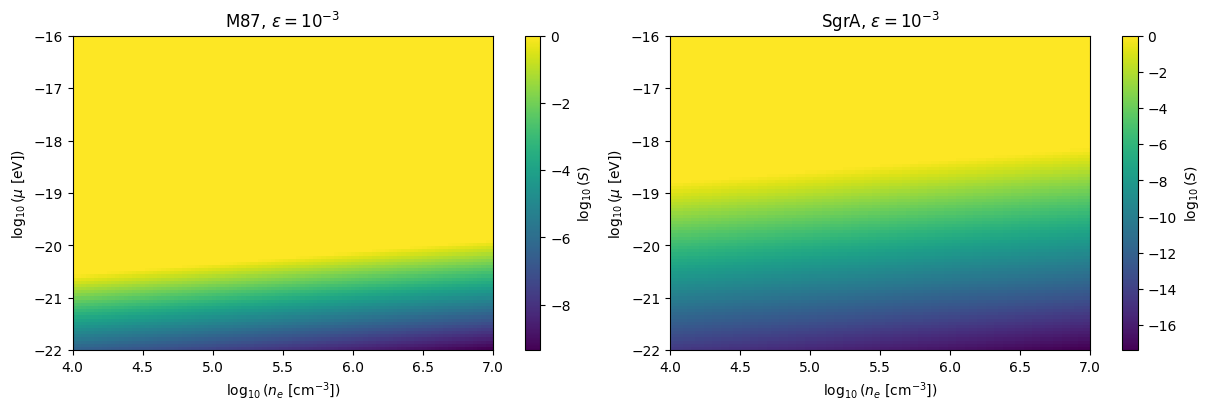

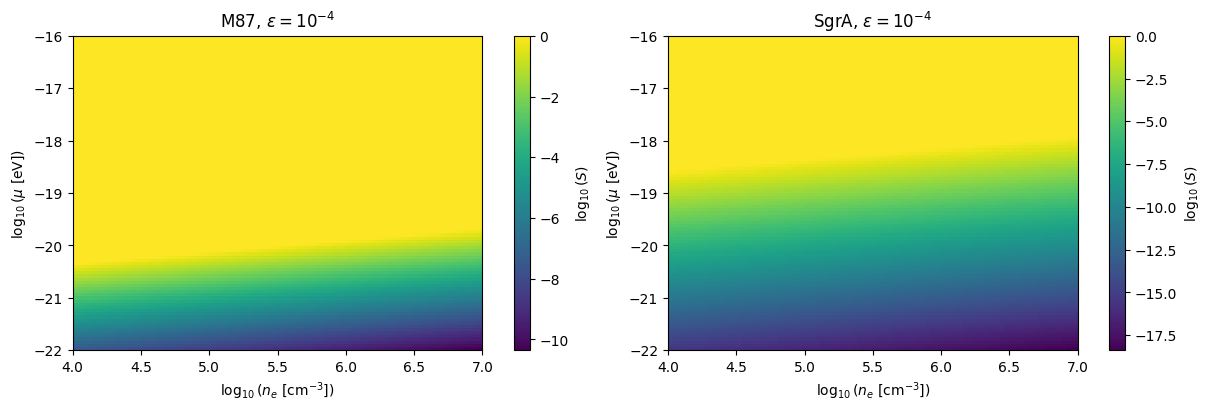

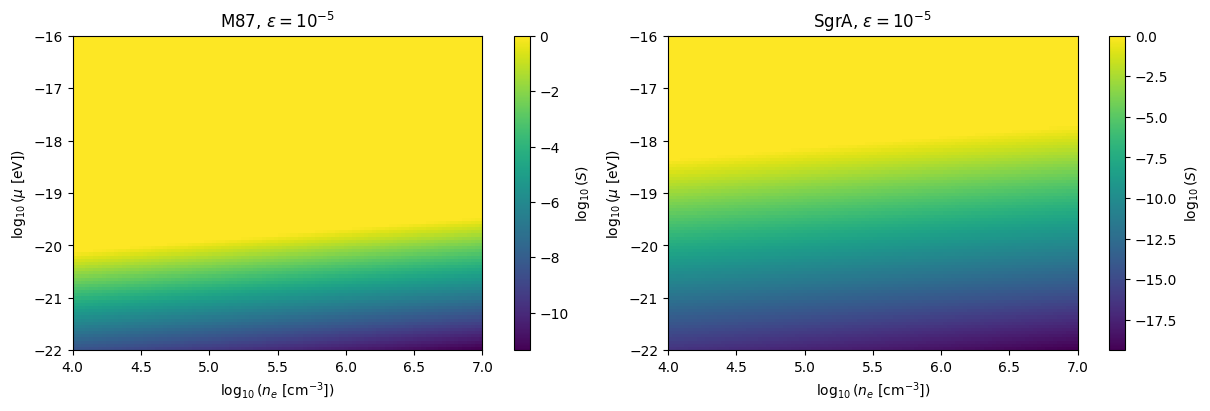

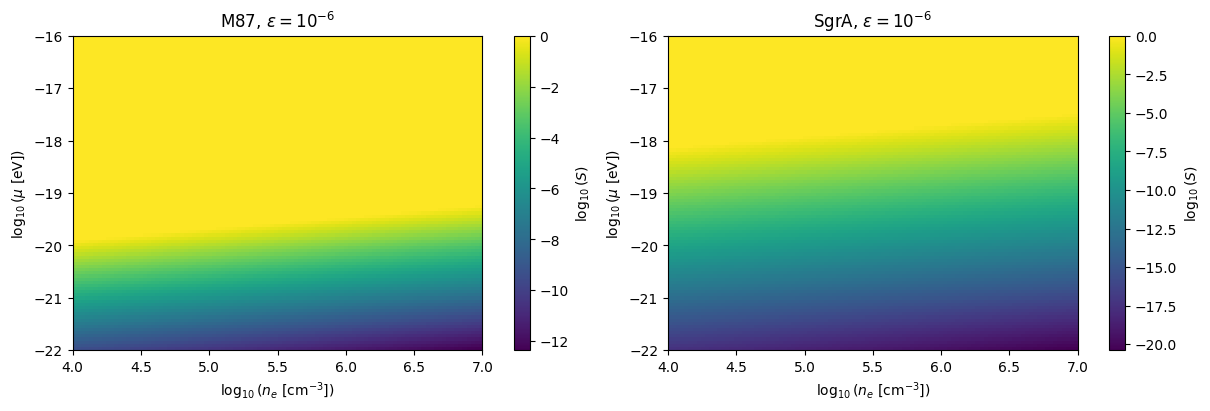

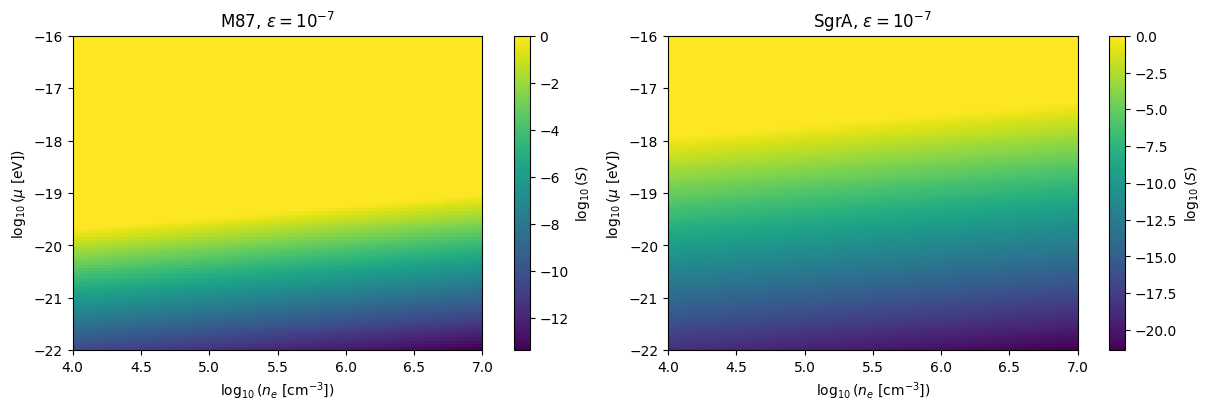

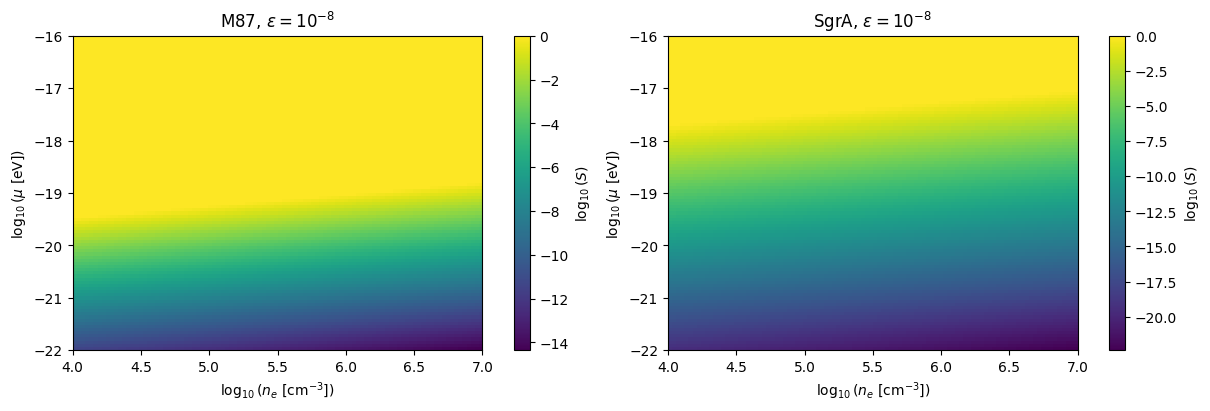

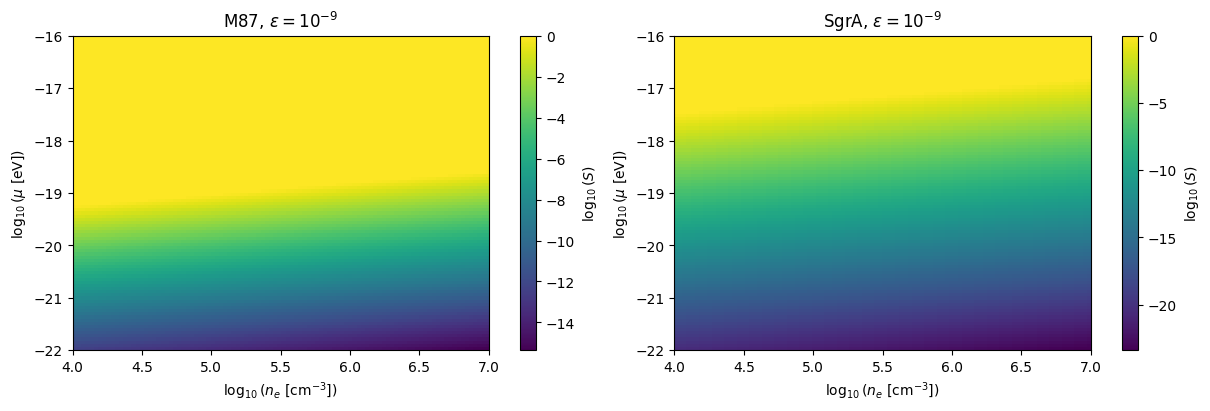

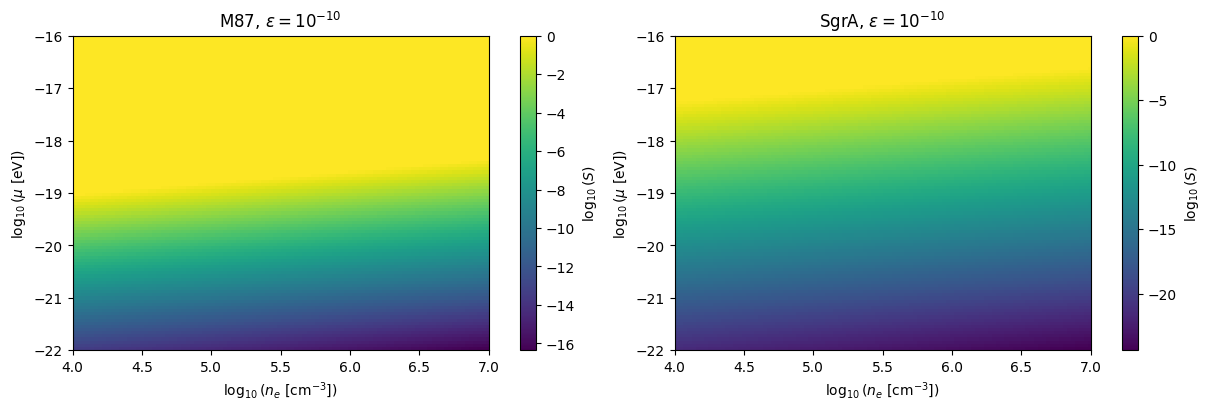

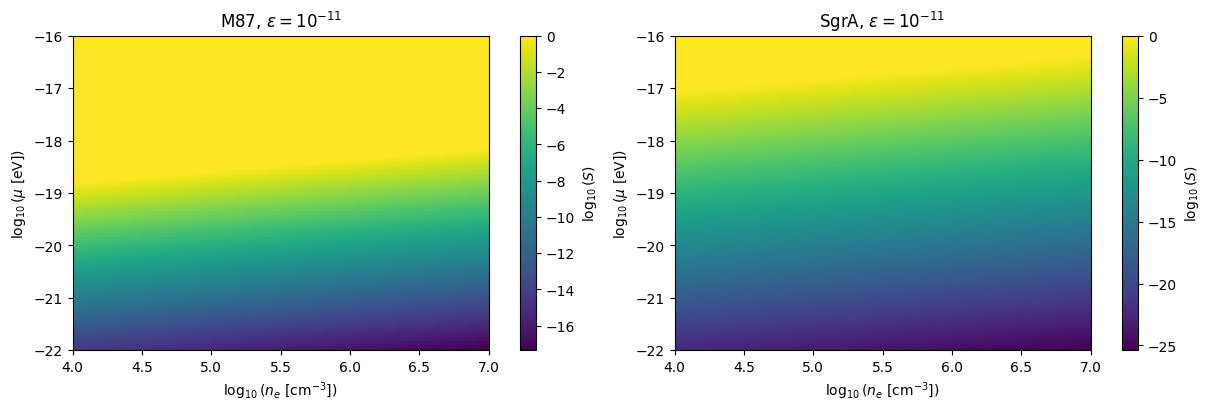

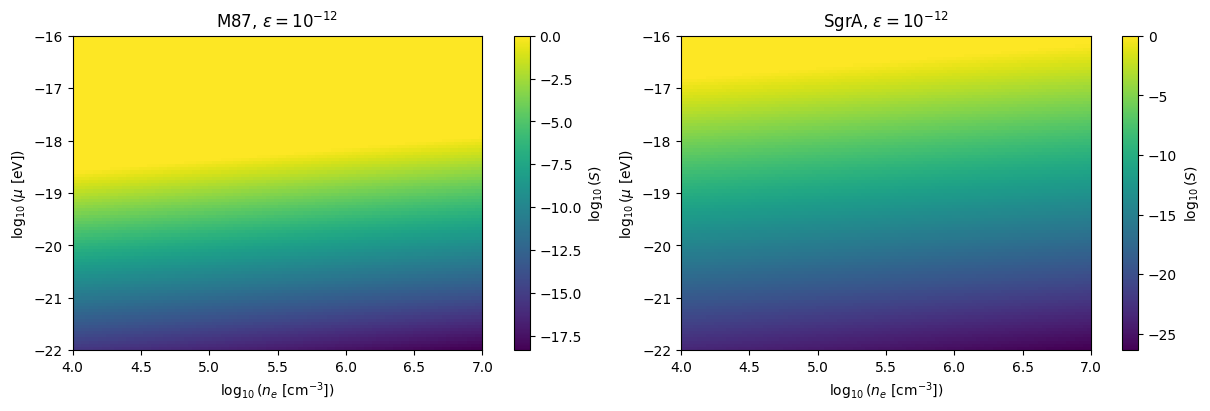

In [3]:
# Define solar mass in kg
M_sun = 1.98847e30

# Black hole specifications: mass (kg) and Lambda (V/m)
bh_specs = {
    "M87": {"mass": 6.5e9 * M_sun, "Lambda": 2.2e14},
    "SgrA": {"mass": 4e6 * M_sun, "Lambda": 3.6e17},
}

# Kinetic mixing parameter
epss = 10.0 ** - np.arange(2, 13)

# Range of dark photon masses (eV) and electron densities (cm^-3)
mus_eV = np.logspace(-22, -16, 100)
n_es_cm3 = np.logspace(4, 7, 100)

# For each eps, create a new figure with two subplots (one for each black hole)
for eps in epss:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    for j, (bh_name, specs) in enumerate(bh_specs.items()):
        M_kg = specs["mass"]
        Lambda = specs["Lambda"]
        mu_grid, ne_grid = np.meshgrid(mus_eV, n_es_cm3, indexing="ij")
        alpha = alpha_from_M_mu(M_kg, mu_grid)
        E = E_obs_from_eps_alpha(eps, alpha, Lambda)
        a0, gamma = gamma_from_E_and_mu(E, mu_grid)
        omega_p_eV = omega_p_eV_from_ne_cm3(ne_grid)
        S_grid = np.minimum(gamma * (mu_grid / omega_p_eV) ** 2, 1.0)
        ax = axes[j]
        im = ax.imshow(
            np.log10(S_grid),
            origin="lower",
            extent=[np.log10(n_es_cm3[0]), np.log10(n_es_cm3[-1]),
                    np.log10(mus_eV[0]), np.log10(mus_eV[-1])],
            aspect="auto",
            cmap="viridis"
        )
        ax.set_xlabel(r"$\log_{10}(n_e\ [\mathrm{cm}^{-3}])$")
        ax.set_ylabel(r"$\log_{10}(\mu\ [\mathrm{eV}])$")
        eps_exp = int(np.log10(eps))
        ax.set_title(rf"{bh_name}, $\epsilon = 10^{{{eps_exp}}}$")
        fig.colorbar(im, ax=ax, label=r"$\log_{10}(S)$")
    plt.show()